# 2021-01-01 • Debug parallel `_calc_STA`

Throwaway nb, but still wanna document/archive.

Debugging wrong `_calc_STA` due to parallel numba.

## Setup

In [1]:
from voltage_to_wiring_sim.support.notebook_init import *

Preloading:
 - numpy … (0.10 s)
 - matplotlib.pyplot … (0.21 s)
 - numba … (0.30 s)

Importing from submodules … ✔

Imported `np`, `mpl`, `plt`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga`<br>on **Fri 01 Jan** 2021, at 21:36 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/e8b18931d4b2cd937b12f6a07661db75bd994021
) (Fri 01 Jan 2021, 15:02).

Uncommited changes to:
```
 M codebase/voltage_to_wiring_sim/N_to_1_simulation.py
 M codebase/voltage_to_wiring_sim/spike_trains.py
 M codebase/voltage_to_wiring_sim/support/plot_style.py
?? notebooks/2020_12_30__vary_params.ipynb
```

## Sim

In [3]:
params = v.N_to_1_simulation.default_params
v.pprint(params)

N_to_1_SimParams
----------------
                time_grid = {'duration': 600, 'start': 0, 'timestep': 0.0001}
num_incoming_spike_trains = 15
               spike_rate = 20
                   Δg_syn = 8E-10
                    τ_syn = 0.007
            neuron_params = {'C': 1e-10, 'a': 30.0, 'b': -2e-09, 'c': -0.05, ...}
        imaging_spike_SNR = 10


(All quantities are in unprefixed SI units: second, Hz, Farad, Siemens …. Pretty printing, in human readable units, is not here yet).

In [4]:
%%time
sim_result = v.N_to_1_simulation.simulate(params);

Wall time: 1.01 s


A short time slice to visualise part of the generated signals.

In [6]:
zoom = v.TimeGrid(
    start=1 * minute,
    duration=1 * second,
    timestep=params.time_grid.timestep
);

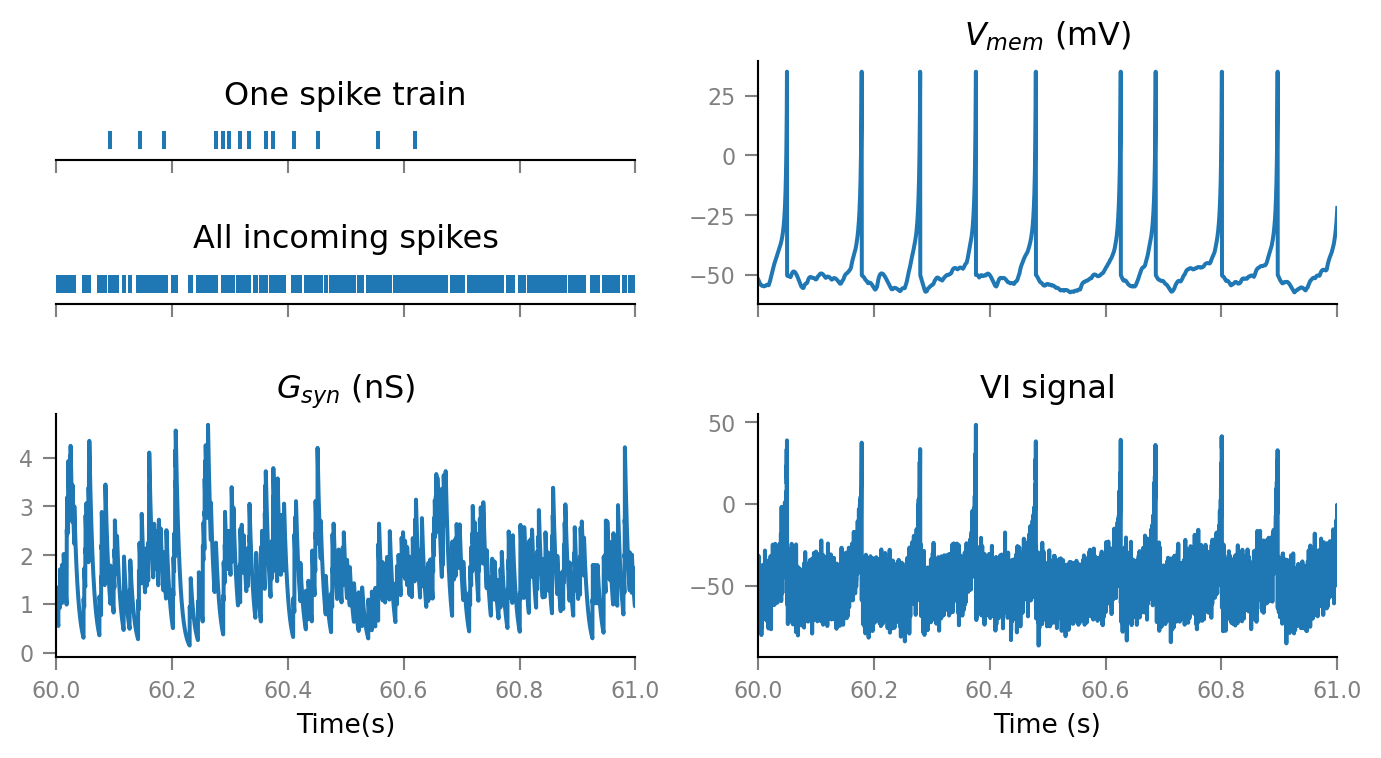

In [65]:
v.N_to_1_simulation.plot(sim_result, zoom)

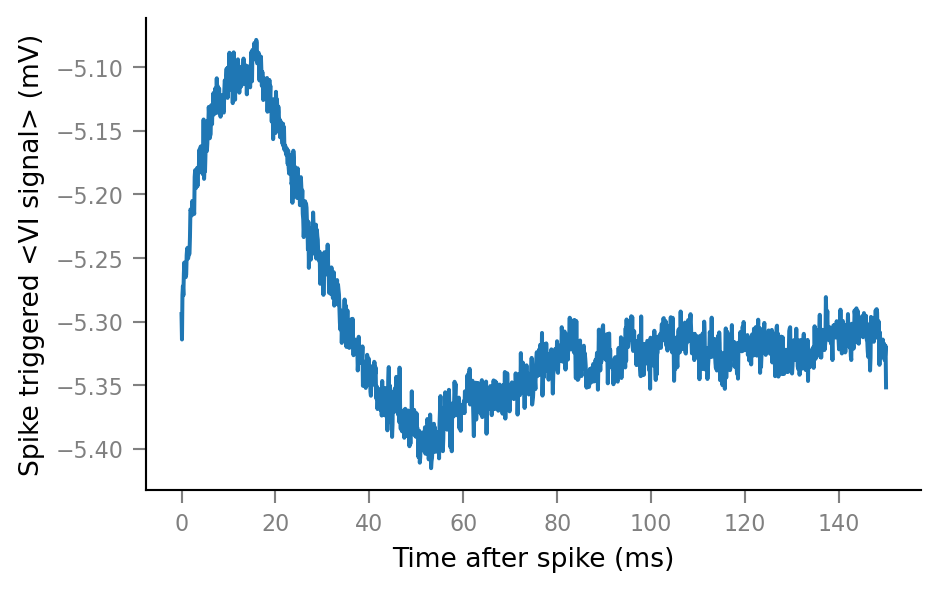

In [77]:
STA = v.calculate_STA(sim_result.VI_signal, sim_result.spike_trains[0], window_duration=150 * ms);
v.plot_STA(STA)

In [147]:
def calculate_STA(
    VI_signal,
    spike_times,
    window_duration,
):
    dt = VI_signal.timestep
    spike_indices = v.spike_trains.to_indices(spike_times, dt)
    window_tg = v.TimeGrid(window_duration, dt)
    STA = _calc_STA(VI_signal, spike_indices, window_tg.N)
    return v.support.Signal(STA, dt)


from numba import njit, prange

@v.support.array_wrapper.strip_NDArrayWrapper_inputs
@njit(parallel=False)
def _calc_STA(
    VI_signal: np.ndarray,
    spike_indices: np.ndarray,
    window_length: int,
) -> np.ndarray:
    num_spikes = len(spike_indices)
    num_windows = 0
    STA = np.zeros(window_length)
    for i in prange(num_spikes):
        start_ix = spike_indices[i]
        end_ix = start_ix + window_length
        if end_ix < len(VI_signal):
            STA += VI_signal[start_ix:end_ix]
            num_windows += 1
    return STA / num_windows

In [105]:
len(sim_result.spike_trains[0])

12001

### profile

In [144]:
N = 10_000_000
sig = np.random.randn(N)
times = np.random.randint(0, N, size=1_000_000);

#### parallel

In [146]:
%%time
STA = _calc_STA(sig, times, 1500);

Wall time: 559 ms


#### serial

In [150]:
%%time
STA = _calc_STA(sig, times, 1500)

Wall time: 1.11 s


Ok nice, we still get 2x improvement :)

### found cause

11998


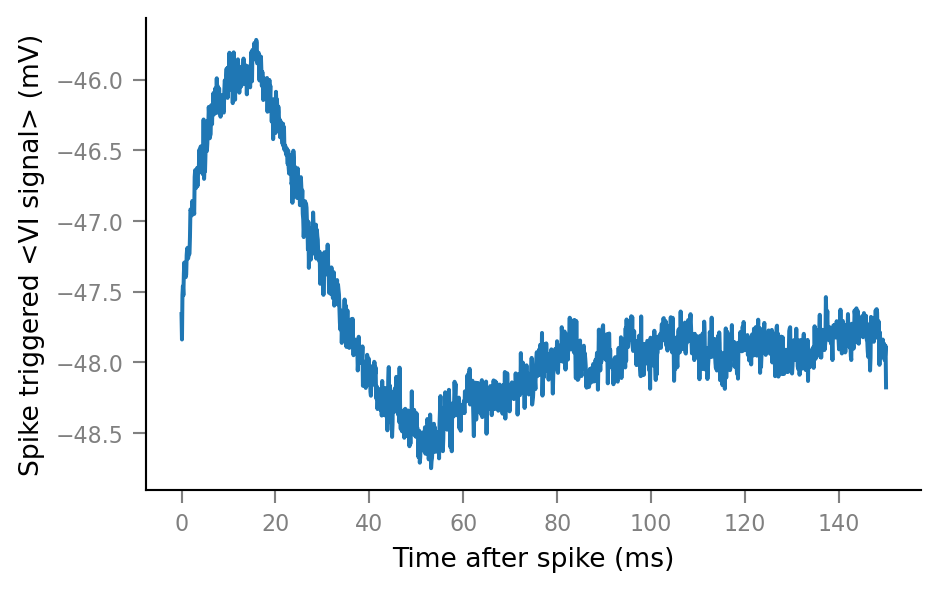

In [119]:
STA = calculate_STA(sim_result.VI_signal, sim_result.spike_trains[0], window_duration=150 * ms);
v.plot_STA(STA)

11998


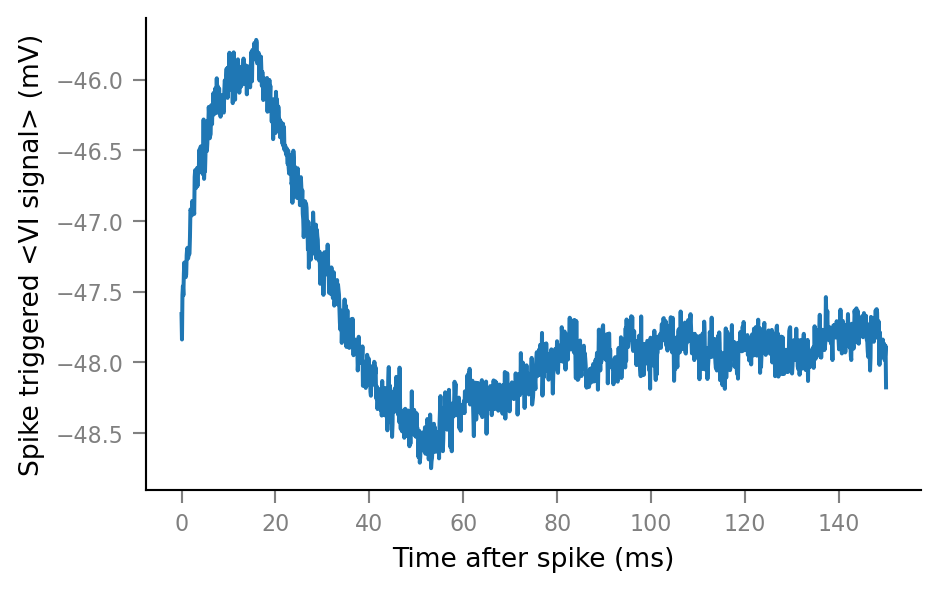

In [116]:
STA = calculate_STA(sim_result.VI_signal, sim_result.spike_trains[0], window_duration=150 * ms);
v.plot_STA(STA)

### Vanilla code not parallel (correct):

11998


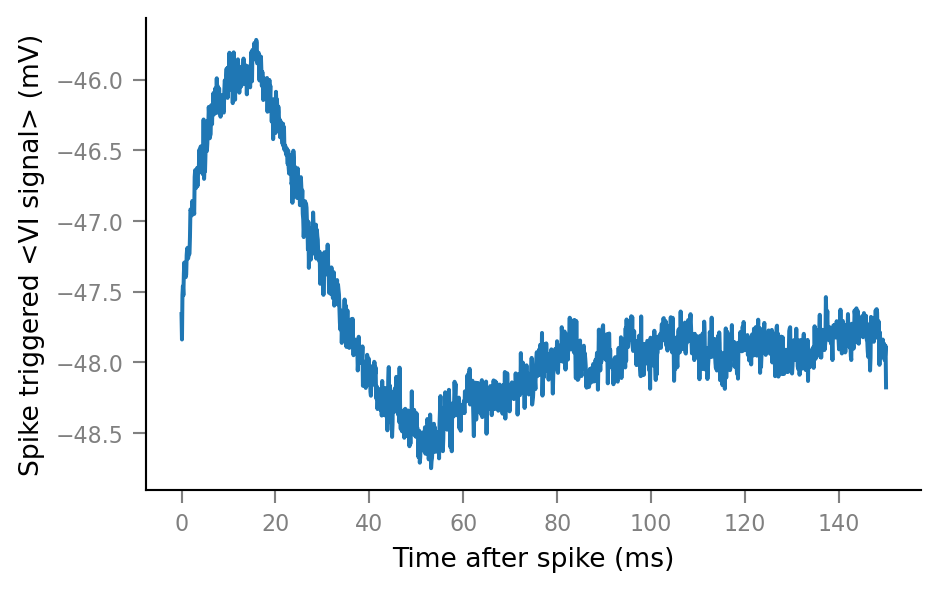

In [98]:
STA = calculate_STA(sim_result.VI_signal, sim_result.spike_trains[0], window_duration=150 * ms);
v.plot_STA(STA)

### Vanilla code but parallel:

108006


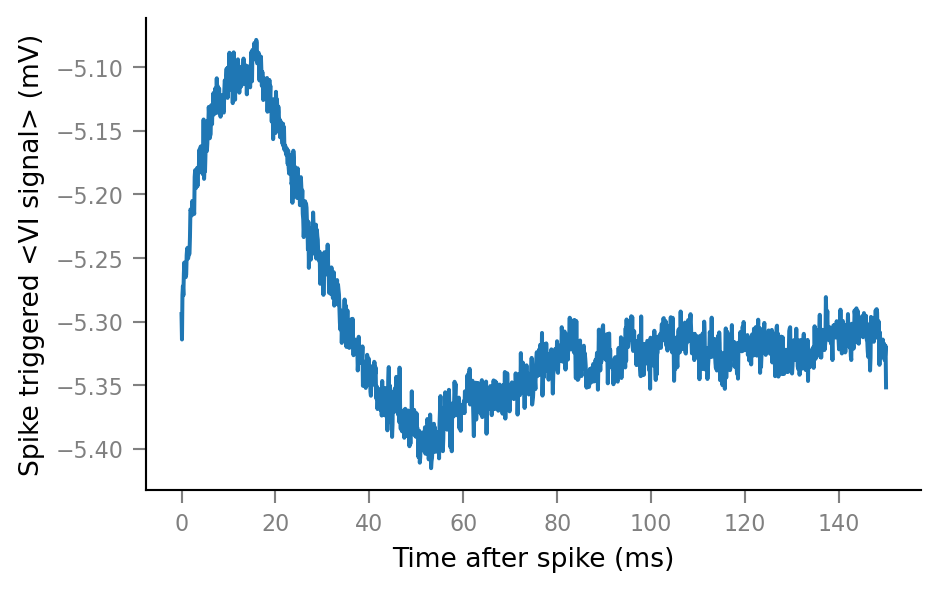

In [94]:
STA = calculate_STA(sim_result.VI_signal, sim_result.spike_trains[0], window_duration=150 * ms);
v.plot_STA(STA)

### Parallel with copying num_windows (no change):

108006


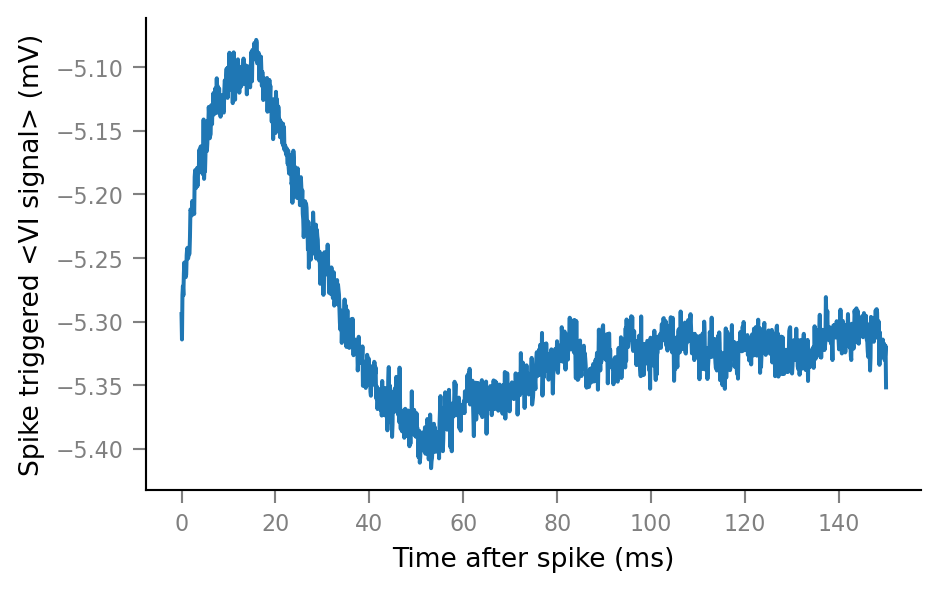

In [104]:
STA = calculate_STA(sim_result.VI_signal, sim_result.spike_trains[0], window_duration=150 * ms);
v.plot_STA(STA)

In [ ]:
ca

In [28]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Wed 30 Dec** 2020, at 18:17 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/1b3a4f6000c5f7d90f8c184d1b37fcbaa76e9fa5
) (Wed 30 Dec 2020, 18:16).

Uncommited changes to:
```
 M notebooks/2020_12_30__test_all_connections.ipynb
```

Platform:

Windows-10
CPython 3.8.3 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.2
matplotlib           3.3.2
numba                0.51.2
seaborn              0.10.1
scipy                1.5.2
scikit-learn         0.23.2
preload              2.1
py-cpuinfo           7.0.0
nptyping             1.3.0
tqdm                 4.55.0
